In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


# [1]. Reading Data

In [3]:
# Using the SQLite table to read the data
con = sqlite3.connect("/kaggle/input/amazon-fine-food-reviews/database.sqlite")

# We are not eliminating the records which has Score value '3', Because '3' means nuetral value which doesn't help in finding the polarity of the review.
# We are limiting 5000 records for faster results.
#filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000", con)
df = pd.read_sql_query("SELECT * FROM Reviews", con)
#print(filtered_data)


print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

<b>Get information about the number of datapoints in the dataset.</b>

In [4]:
print("Number of datapoints: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of datapoints:  568454
Number of features:  10


<b> Get Mean/Median/Percentile/Standard Deviation information </b>

In [5]:
print(df.describe())

                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09  


<b> Number of reviews corresponding to each of the rating </b>

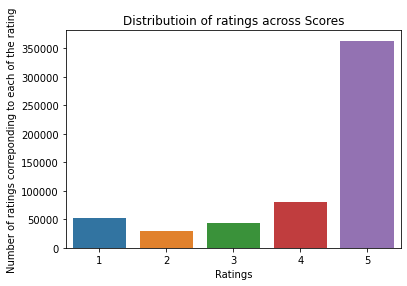

5    63.878871
4    14.188483
1     9.194763
3     7.501047
2     5.236835
Name: Score, dtype: float64


In [6]:
df["Score"].value_counts()
sns.countplot(data = df, x="Score")
plt.title("Distributioin of ratings across Scores")
plt.xlabel("Ratings")
plt.ylabel("Number of ratings correponding to each of the rating")
plt.show()

print(df["Score"].value_counts()/sum(df["Score"].value_counts())*100)

<b>Observation:- </b> From the above plot, we can figure out that 63.8% reviews from Amazon have the rating 5 and 14.1% reviews have rating 4. which means cumulatively almost there are 78% reviews from Amazon are positive and remaining are Nuetral and Negative.

In [7]:
#We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

#Filter only positive and negative reviews. Do not consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
filtered_data['rating_Score'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,rating_Score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1,1


#  [2]. Exploratory Data Analysis


## [1] Data Cleaning:

<b>Deduplication</b>

In [8]:
#Get the number of duplicate entries in the dataset.
filtered_data.duplicated(subset=["UserId","ProfileName", "Time", "Text"]).value_counts()

False    364173
True     161641
dtype: int64

<b>Observation:-</b> we have 161641 duplicate records which means product id could be different but product is same with difference variant

In [9]:
#Display number of entries from the same user id, who has provided review more than one time for different products.
display = pd.read_sql_query("SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) FROM REVIEWS GROUP BY UserId HAVING COUNT(*) > 1 ", con)
print(display.head())


               UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2  


In [10]:
display = pd.read_sql_query("SELECT * FROM REVIEWS WHERE UserId = 'AR5J8UI46CURR' ORDER BY ProductId", con)
print(display.head())

       Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS

<b>Observation:-</b> As we see from the above reult, The user has given the ratings for multiple products at a same time. But this cant be possible. So basically, this could be same product with different variants. Hence they considered as different products.

In [11]:
print("Size of data before removal of duplicates: ", filtered_data.shape)
print(filtered_data["rating_Score"].value_counts())

Size of data before removal of duplicates:  (525814, 13)
1    443777
0     82037
Name: rating_Score, dtype: int64


In [12]:
#Remove duplicates
filtered_data.drop_duplicates(subset=["UserId", "ProfileName", "Time", "Text"], keep="first", inplace=True)
print("After removal size of data: ", filtered_data.shape)
print(filtered_data["rating_Score"].value_counts())

After removal size of data:  (364173, 13)
1    307063
0     57110
Name: rating_Score, dtype: int64


In [13]:
print("Percenratage of redundent removed: ", np.round(((525814-364173)/525814)*100, 2) )

Percenratage of redundent removed:  30.74


<b>Helpful Numerator Greater than Helpful Denominator is not possible.</b>

In [14]:
#HelpfulnessDenominator = Number of users who indicated if the reviews are helpful or not.
#HelpfulnessNumerator = Number of people who indicated if the review is helpful.
#Removing the entries where HelpfulnessNumerator <= HelpfulnessDenominator. 
filtered_data = filtered_data[filtered_data["HelpfulnessNumerator"] <= filtered_data["HelpfulnessDenominator"]]
filtered_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,rating_Score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1,1


In [15]:
print("Number of reviews which does not has any upvote: ", filtered_data[filtered_data["HelpfulnessNumerator"] == 0].shape[0])
print("Total Number of Unique Users: ", filtered_data["UserId"].value_counts().shape[0])
print("Total Number of Unique Products: ", filtered_data["ProductId"].value_counts().shape[0])

Number of reviews which does not has any upvote:  190812
Total Number of Unique Users:  243414
Total Number of Unique Products:  65501


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following steps:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

#### [1]. <b>HTML Tag removal</b>

In [16]:
#Function to clean html tags from a sentence
import re
def removeHtml(sentence): 
    cleaned_text = re.sub("<.*?>",' ',sentence)
    return cleaned_text

removeHtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

' I Want This  text!   '

### [2]. Punctuations removal

In [17]:
# Removes all Punctuations and special characters
def removePunctuations(sentence):
    return re.sub("[^a-zA-Z]", " ", sentence)

removePunctuations("fsd*?~,,,( sdfsdfdsvv)#")

'fsd        sdfsdfdsvv  '

### [3]. Removal of words with numbers

In [18]:
# Removes the words which has numbers
def removeNumbers(sentence):
    return re.sub('\S*\d\S*', ' ', sentence).strip()
removeNumbers("The5 number is removed removed55")

'number is removed'

### [4]. Removal of urls

In [19]:
#Remove URL from sentences which has http or 'www.' words
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)

removeURL("https://www.google.com/search?client=ubuntu&channel=fs&q=google+drive+storage+plans&ie=utf-8&oe=utf-8 notice the URL is removed")
    

'  notice the URL is removed'

### [5]. Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.

In [20]:
# https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

removePatterns("This looks soooooooo good! I am so happpyyy")

'This looks  good! I am so '

### [6]. Expand the most common english contractions

In [21]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
# Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

### [7]. Stopwords
<b>Stopwords are the words which doesnot have any meaning in the sentence. It doesn't help to understand the context of the sentence</b>

In [22]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer



#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = set(['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

custom_stopwords = default_stopwords - excluding

print(custom_stopwords)

{'you', 'been', 'off', 'once', 'is', 's', 'was', 'having', 'our', 'be', 'this', 'does', 'below', 'yourself', 'an', 'the', 'then', 'very', "you're", 'itself', 'on', 'doing', 'few', 'out', 'their', 'why', 'such', 'at', 'that', 'ma', 'can', "it's", 'after', 'there', 'as', 'through', 'which', 'are', 'own', 'up', 'until', 'she', 'to', 'again', 've', 'no', 're', 'most', "shan't", 'did', 'its', 'those', 'more', 'o', 'all', 'by', 'over', 'him', 'other', 'during', 'your', 'were', 'he', 'any', 'now', 'in', 'how', 'has', 'before', 'with', 'both', "should've", "you'll", 'from', 'and', 'themselves', 'above', 'between', 'ours', 't', 'under', 'am', 'down', 'just', 'himself', 'have', 'they', 'theirs', 'do', 'y', 'should', 'here', 'my', "she's", "that'll", 'herself', "you've", 'so', 'd', 'of', 'only', 'or', 'a', 'who', 'about', 'if', 'same', 'yourselves', 'each', 'but', 'some', 'when', 'we', "you'd", 'whom', 'his', 'too', 'what', 'where', 'will', 'shan', 'them', 'ourselves', 'than', 'i', 'while', 'your

### [8]. Stemming:
<b>It helps to find the stem/root of the word. It removes the prefixes or suffixes in the word and gives base/root word</b><br>
<b>Porter Stemmer and SnowBall Stemmer. Porter Stemmer</b> is computationally expensive where as <b>SnowBall stemmer</b> is slighely faster compared to Porter.

In [23]:
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


<b>Preprocessing output for one review. </b>

In [24]:
print(filtered_data['Text'][4:5].values)
final_string = []
for sent in filtered_data['Text'][4:5].values:
    filtered_sentence = []
    print("Review: ", sent)
    sent=removeHtml(sent)# removal of HTML tags
    sent=removePunctuations(sent)# remove Punctuation Symbols
    for w in sent.split():
        print("==============>", w)
        if(w.isalpha() and len(w) > 2): # word shold not be number and lnght of word should contain minimum 3 letters.
            if(w.lower() not in custom_stopwords):
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected Stem word: ", s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
        else:
            print("Word contains number or Word has less than 2 characters.")
    s = b" ".join(filtered_sentence)
    final_string.append(s)
    
    print('*' * 50)
    print("finally selected words from the reviews are: ", final_string)

['Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.']
Review:  Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taffy lover, this is a deal.
==============> Great
Selected Stem word:  b'great'
==============> taffy
Selected Stem word:  b'taffi'
==============> at
Word contains number or Word has less than 2 characters.
==============> a
Word contains number or Word has less than 2 characters.
==============> great
Selected Stem word:  b'great'
==============> price
Selected Stem word:  b'price'
==============> There
Eliminated as it is a stopword
==============> was
Eliminated as it is a stopword
==============> a
Word contains number or Word has less than 2 characters.
==============> wide
Selected Stem word:  b'wide'
==============> assortment
Selected Stem word:  b'assort'
==============> of
Word contains number or Word has less th

100%|██████████| 70255/70255 [00:00<00:00, 787344.67it/s]


Text(0, 0.5, 'Number of Words')

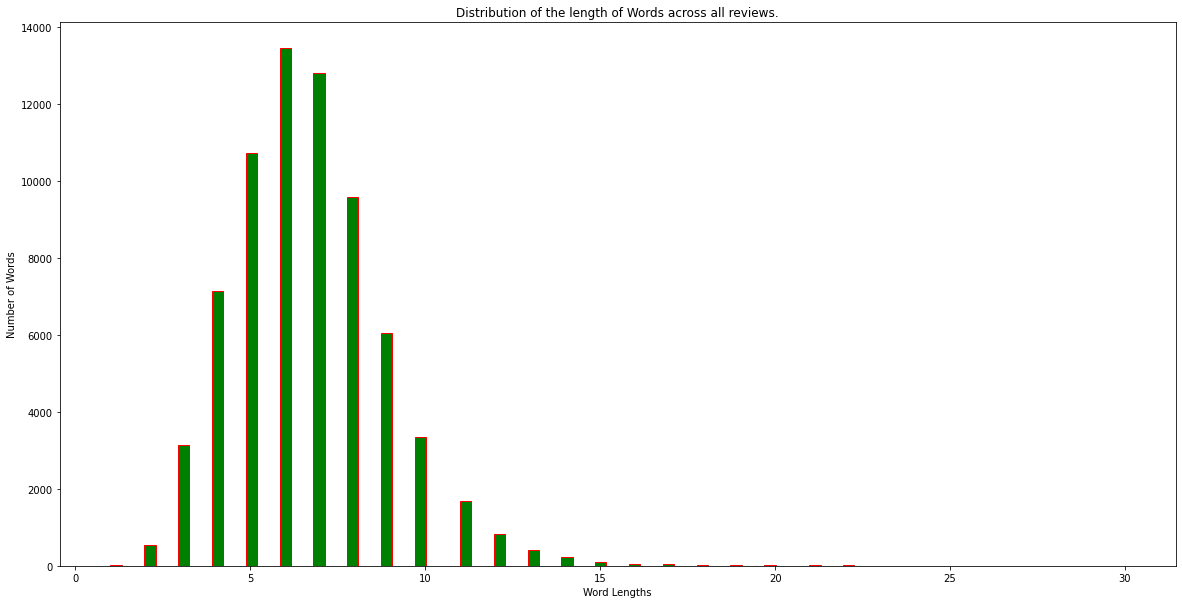

In [25]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []
for review in tqdm(filtered_data["Text"].values):
    filtered_sentence = []
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    for word in review.split():
        if(word not in custom_stopwords):          
            stemed_word=(sno.stem(word.lower()))
            total_words.append(stemed_word)
total_words = list(set(total_words)) # Get the list of unique words

dist = []
for i in tqdm(total_words):
    dist.append(len(i))

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'green', edgecolor = 'red', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

<b>Conclusion from the above histogram:</b><br>
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [26]:
from tqdm import tqdm
total_words = []
preprocessed_reviews = []
all_negative_words = []
all_positive_words = []
count = 0
for review in tqdm(filtered_data["Text"].values):
    filtered_sentence = []
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    for word in review.split():
        if((word not in custom_stopwords)  and (2<len(word)<16)):          
            stemed_word=(sno.stem(word.lower()))
            filtered_sentence.append(stemed_word)
            if(filtered_data["SentimentPolarity"].values)[count] == 'Positive':
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(filtered_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
    
    review = " ".join(filtered_sentence)
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
# Save the list of positive and list of negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)

# Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
filtered_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))
    

100%|██████████| 364171/364171 [10:15<00:00, 591.32it/s]


The length of the data corpus is : 364171


In [27]:
#No Stemming

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews

count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    

for review in tqdm(filtered_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            cl_word=cleaned_words.lower()                                 
            filtered_sentence.append(cl_word)
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
filtered_data['CleanedText_NoStem']=preprocessed_reviews

100%|██████████| 364171/364171 [03:07<00:00, 1937.40it/s]


In [28]:
## Similarly we do preprocessing for summary column also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
string=' '    
stemed_word=' '

for summary in tqdm(filtered_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
filtered_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
filtered_data['Combined_Reviews'] = filtered_data['CleanedText'].values + " " + filtered_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
filtered_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

100%|██████████| 364171/364171 [00:44<00:00, 8110.77it/s]


File is saved as 'totally_processed_DB.sqlite'


<b>Positive and Negative words in Reviews</b>

In [29]:
from collections import Counter
print("No. of Positive words: ", len(all_positive_words))
print("No. of Positive words: ", len(all_negative_words))
positive = Counter(all_positive_words)
negative = Counter(all_negative_words)
print("\n Most common Positive words: ", positive.most_common(10))
print("\n Most common Negative words: ", negative.most_common(10))

No. of Positive words:  11790862
No. of Positive words:  2426280

 Most common Positive words:  [('not', 292389), ('like', 140357), ('tast', 130615), ('good', 113380), ('flavor', 110911), ('love', 107545), ('great', 104300), ('use', 103673), ('one', 97178), ('product', 91900)]

 Most common Negative words:  [('not', 95184), ('tast', 35016), ('like', 32598), ('product', 28579), ('would', 23275), ('one', 20699), ('flavor', 19860), ('tri', 17741), ('use', 15273), ('good', 15116)]


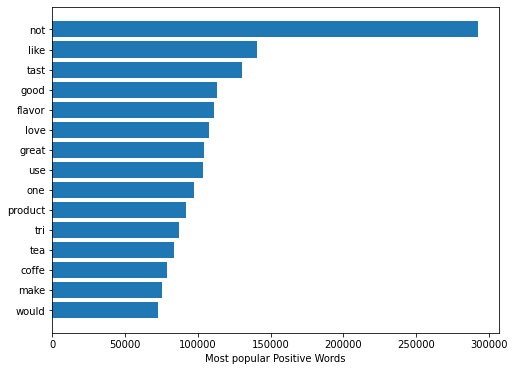

In [30]:
plt.figure(figsize=(8,6))
positive = Counter(all_positive_words)
pos_words = positive.most_common(15)
words = []
no_of_times = []
pos_words.sort(key=lambda x: x[1], reverse=False)
for w, n in pos_words:
    words.append(w)
    no_of_times.append(n)
plt.barh(words, no_of_times)
plt.xlabel("Most popular Positive Words")
plt.show()


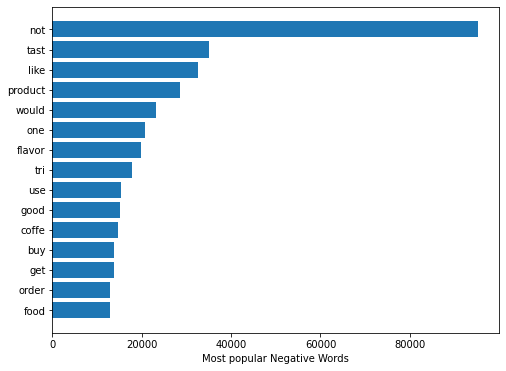

In [31]:
plt.figure(figsize=(8,6))
negative = Counter(all_negative_words)
neg_words = negative.most_common(15)
words = []
no_of_times = []
neg_words.sort(key=lambda x: x[1], reverse=False)
for w, n in neg_words:
    words.append(w)
    no_of_times.append(n)
plt.barh(words, no_of_times)
plt.xlabel("Most popular Negative Words")
plt.show()

<b>Observation: </b>

* From the above 2 plots,We can notice that 'not', 'tast', 'like', 'good' are most common words in both positive and negative reviews.
* 'good' and 'great' are some of the most popular words in Poistive reviews. 
* Similary "not" and "tast" are some of the most popular words in negative reviews.
* tast,good,etc.. are some of the most common words in both positive and negative reviews <b>because there may be a not before it like 'not good', 'not tasty'</b>

<b>Word Cloud of Whole Dataset</b>

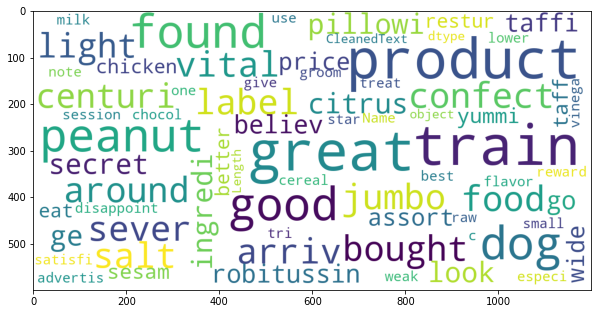

In [32]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
df2 = filtered_data
def show_wordcloud(data):
    wordcloud = WordCloud(background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df2["CleanedText"])

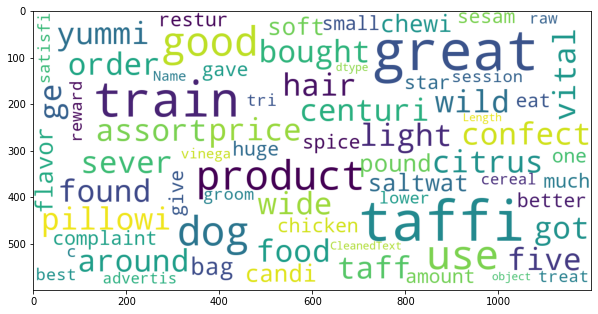

In [33]:
show_wordcloud(df2.loc[df2["SentimentPolarity"] == "Positive", "CleanedText"])

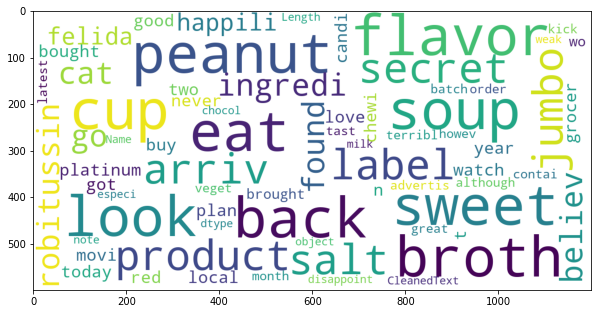

In [34]:
show_wordcloud(df2.loc[df2["SentimentPolarity"] == "Negative", "CleanedText"])

# [3]. NLP (Natural Language Processing)
<br>
<b>NLP: </b> is automatic manipulation of natural language, like speech and text. It helps the computers, how to program the large amount of natural language data. Examples: Siri, Alexa and Google Mini which understands human language and converts into its mahcnie understandable language.
<br><br>
<b>Sentiment Analysis</b> is a technique to understand the context from the given piece of text. i.e. wether the author is subjective or objective or even positive or negative. In our case it helps to find the polarity of the review.
<br><br>
<b>Document</b> is generally a distinct text that can be considered as individual pragraph or event sentence as a document. <br>
In our case each review is document.
<br><br>
<b>Data Corpus </b>usually a large collection of data that can be used to infere, validate lingustic rules and to do some statistical analysis.
<br><br>

<b>Bag of words: </b> It creates the set of unique words for the document corpus and for each review, if word exists, BOW fills with number of occurences of the word else fills with zero.

In [35]:
# Unigram - Takes one word into consideration to create one-dimension
from sklearn.feature_extraction.text import CountVectorizer
df2 = filtered_data
uni_gram = CountVectorizer()
uni_gram_vectors = uni_gram.fit_transform(df2["CleanedText"].values)
print("the type of Unigram CountVectorizer is: ", type(uni_gram_vectors))
print("the shape of Unigram CountVectorizer is: ", uni_gram_vectors.shape)
print("the number of unique words in Unigram CountVectorizer is: ", uni_gram_vectors.shape[1])

the type of Unigram CountVectorizer is:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of Unigram CountVectorizer is:  (364171, 69452)
the number of unique words in Unigram CountVectorizer is:  69452


In [36]:
# Bi-gram - Takes one word and two words into consideration to create one-dimension
from sklearn.feature_extraction.text import CountVectorizer
df2 = filtered_data
bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = uni_gram.fit_transform(df2["CleanedText"].values)
print("the type of Bi-gram CountVectorizer is: ", type(bi_gram_vectors))
print("the shape of Text Bow Vectorizer is: ", bi_gram_vectors.shape)
print("the number of unique words in Bi-gram Vectorizer is: ", bi_gram_vectors.shape[1])

the type of Bi-gram CountVectorizer is:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of Text Bow Vectorizer is:  (364171, 69452)
the number of unique words in Bi-gram Vectorizer is:  69452


<b>TF-IDF: </b><br><br>
TFIDF = TF x IDF <br>
TF = term-frequency: Number of times word occurs in the document. <br>
IDF = inverse document frequency: This downscales the words which occurs a lot across documents in the data corpus. <br><br>
tf-idf gives more weightage to most frequent occuring words and it is one of the most popular term-weighting scheme used in recommendation systems.




In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
df2 = filtered_data
tfidf = TfidfVectorizer(ngram_range=(1,2)) # Both Unigrams and bi-grams
tfidf_vec = tfidf.fit_transform(df2["CleanedText"].values)
print("Type of Count Vectorizer is: ", type(tfidf_vec))
print("Shape of countvectorzer: ", tfidf_vec.shape)
print("Number of unique words including both uni-gram and bi-gram: ", tfidf_vec.shape[1])

Type of Count Vectorizer is:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of countvectorzer:  (364171, 2853786)
Number of unique words including both uni-gram and bi-gram:  2853786


In [38]:
features = tfidf.get_feature_names()
print("tfidf feature names are: ", features[0:10])
top_feature_ind = np.argsort(tfidf_vec[3000, :].toarray()[0])[::-1][:20] #Top 20 features indices of 3000th review
top_feat = [(features[i], tfidf_vec[3000, :].toarray()[0][i]) for i in top_feature_ind]
print(top_feat)

tfidf feature names are:  ['aa', 'aa pleas', 'aabout', 'aabout nostalg', 'aabsolut', 'aabsolut love', 'aachen', 'aachen munich', 'aachen printen', 'aacur']
[('stretch strong', 0.40468565143223306), ('cup stretch', 0.3764059775849633), ('delici mocha', 0.3550132301604679), ('delici hot', 0.27184838393715), ('chocol best', 0.2627100171737551), ('coffe delici', 0.25352259010181266), ('best cup', 0.2447591743307124), ('stretch', 0.23172938761649242), ('delici', 0.22068773829394622), ('strong coffe', 0.21025150024663777), ('mocha', 0.20116087990657064), ('hot chocol', 0.19408034754569445), ('strong', 0.12887062273844008), ('hot', 0.12380216239842681), ('chocol', 0.11667890596690766), ('cup', 0.11086474168760002), ('coffe', 0.09854840273765093), ('best', 0.09551594714589538), ('flavor abund', 0.0), ('flavor acacia', 0.0)]


<b>Word2Vec: </b> The BOW, TF-IDF doesnot take semantic meanings into consideration whereas Word2Vec takes semantic meaning into consideration. BOW & TF-IDF creates sparse-vector whereas Word2Vec creates dense vector.

In [39]:
final_string = []
for sent in df2['CleanedText'].values:
    sent = str(sent)
    sentence=[]
    for word in sent.split():
        sentence.append(word)
    final_string.append(sentence) # Arrays of arrays.

In [40]:
%%time

from gensim.models import Word2Vec # Train Word2Vec model using your own text corpus
w2v_model=Word2Vec(final_string,min_count=5,vector_size=50, workers=-1)
# min_count: Ignoring the words which occurs less than 5 times
# size: creating vectors of size 50 for each word


CPU times: user 5.88 s, sys: 31.5 ms, total: 5.91 s
Wall time: 6.21 s


In [41]:
w2v_model.wv.most_similar('great')

[('drone', 0.5730411410331726),
 ('subsist', 0.547382652759552),
 ('goop', 0.5218456387519836),
 ('nutrious', 0.5049791932106018),
 ('herloch', 0.5040960311889648),
 ('profound', 0.4842645525932312),
 ('spitup', 0.48360902070999146),
 ('pipelin', 0.47701165080070496),
 ('panicki', 0.468912273645401),
 ('cypress', 0.46762338280677795)]

In [42]:
w2v_model.wv.most_similar('good')

[('contempl', 0.5459184050559998),
 ('fore', 0.5376627445220947),
 ('transmitt', 0.5212450623512268),
 ('plus', 0.5177525877952576),
 ('absolutley', 0.5140513181686401),
 ('enemi', 0.49608319997787476),
 ('muncher', 0.48962515592575073),
 ('ammount', 0.47963953018188477),
 ('slumber', 0.476764053106308),
 ('jose', 0.467281699180603)]

In [43]:
w2v_words = list(w2v_model.wv.index_to_key)
print("#of words that occured minimum of 5 times: ", len(w2v_model.wv))

#of words that occured minimum of 5 times:  21918


In [44]:
%%time
avg_vec=[]
for sent in final_string:
    cnt = 0;
    sent_vec = np.zeros(50) # Inititalizing with zeros
    for word in sent:
        if word in w2v_words:
            w2v = w2v_model.wv[word]
            sent_vec = sent_vec + w2v 
            cnt += 1
    if cnt != 0:
        sent_vec = sent_vec/cnt
    avg_vec.append(sent_vec)
    
            

CPU times: user 11min 17s, sys: 895 ms, total: 11min 18s
Wall time: 11min 41s


In [45]:
print(len(avg_vec))
print(len(avg_vec[0]))

364171
50


In [46]:
idf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [47]:
tfidf_sent_vectors = []
for sent in tqdm(final_string):
    cnt = 0
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            sent_vec = w2v_model.wv[word]
            tf_idf = (sent.count(word)/len(sent)) * idf[word]
            tf_idf_w2v  = tf_idf * sent_vec
            weight_sum = weight_sum+tf_idf
    if weight_sum != 0:
        sent_vec = sent_vec/weight_sum
    tfidf_sent_vectors.append(sent_vec)
    

100%|██████████| 364171/364171 [12:07<00:00, 500.31it/s]


In [48]:
len(tfidf_sent_vectors)

364171

In [49]:
len(tfidf_sent_vectors[0])

50

In [50]:
# initializing the pca
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

pca = decomposition.PCA()